In [3]:
# When the user searches for a movie we will recommend the top 10 similar movies using our movie recommendation system.
# We will be using an item-based collaborative filtering algorithm for our purpose

#The concept of item-based collaborative filtering is to find similar movies instead of similar users and then 
# recommending similar movies to that ‘A’ has had in his/her past preferences. This is executed by finding every pair of items 
# that were rated by the same user, then measuring the similarity of those rated/viewed/liked/clicked across all user who rated
#both, and finally recommending them movies based on similarity scores.

In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Source : https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [5]:
# Movie dataset has
# movieId – once the recommendation is done, we get a list of all similar movieId and get the title for each 
# movie from this dataset.
# genres – which is not required for this filtering approach

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Ratings dataset has
# userId – unique no for each user.
# movieId – using this feature, we take the title of the movie from the movies dataset.
# rating – Ratings given by each user to all the movies 
# using this we are going to predict the top 10 similar movies.

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Here, we can see that userId 1 has watched movieId 1 & 3 and rated both of them 4.0 but has not rated movieId 2 at all.
# This interpretation is harder to extract from this dataframe. Therefore, to make things easier to understand and work with, 
# we are going to make a new dataframe where each column would represent each unique userId and each row represents each 
# unique movieId.

In [8]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Now, it’s much easier to interpret that userId 1 has rated movieId 1& 3 4.0 but has not
# rated movieId 3,4,5 at all
# (therefore they are represented as NaN )hence their rating data is missing.

# To fix this we replace Nan with 0, making it more understandable and readable

final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly
# engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. 
# Similarly, users who have rated only a handful of movies should also not be taken into account.So with all that taken 
# into account and some trial and error experimentations, we will reduce the noise by adding some filters for the final dataset.

# To qualify a movie, a minimum of 10 users should have voted a movie.
# To qualify a user, a minimum of 50 movies should have voted by the user.

In [11]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

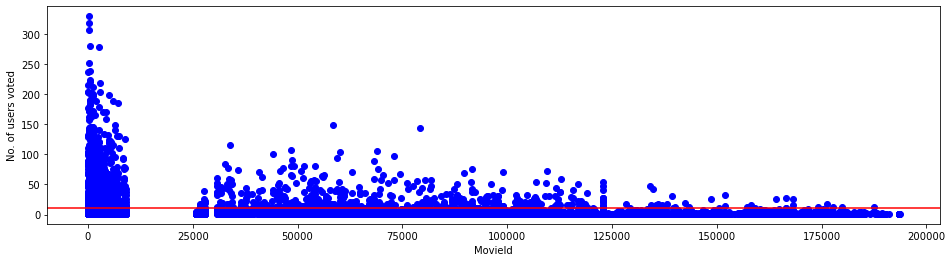

In [12]:
# Let’s visualize the number of users who voted with our threshold of 10 movies

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='blue')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [13]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

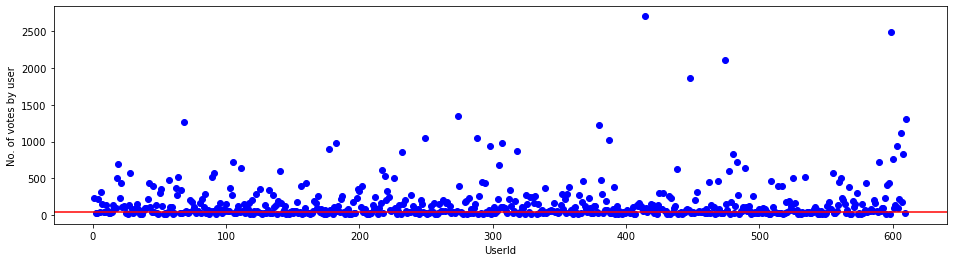

In [14]:
# Let’s visualize the number of votes by each user with our threshold of 50 movie votes

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='blue')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [15]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [16]:
#To reduce the sparsity we use the csr_matrix function from the scipy library

csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [17]:
#We will be using KNN algorithm to compute similarity with cosine distance metric as it is very fast 

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [18]:
# We first check if the movie name input is in the database and if it is we use our recommendation system 
# to find similar movies and sort them based on their similarity distance and output only the top 10 movies 
# with their distances from the input movie.

In [19]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [20]:
#Here are some examples

In [21]:
get_movie_recommendation('Memento')

,Title,Distance
1,American Beauty (1999),0.389346
2,American History X (1998),0.388615
3,Pulp Fiction (1994),0.386235
4,"Lord of the Rings: The Return of the King, The...",0.371622
5,Kill Bill: Vol. 1 (2003),0.350167
6,"Lord of the Rings: The Two Towers, The (2002)",0.348358
7,Eternal Sunshine of the Spotless Mind (2004),0.346196
8,"Matrix, The (1999)",0.326215
9,"Lord of the Rings: The Fellowship of the Ring,...",0.316777
10,Fight Club (1999),0.272380


In [22]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


In [23]:
get_movie_recommendation('Titanic')

,Title,Distance
1,Good Will Hunting (1997),0.460759
2,"Truman Show, The (1998)",0.460628
3,Catch Me If You Can (2002),0.460281
4,"Sixth Sense, The (1999)",0.452878
5,Saving Private Ryan (1998),0.437196
6,Shrek (2001),0.433120
7,Finding Nemo (2003),0.432400
8,Star Wars: Episode I - The Phantom Menace (1999),0.427623
9,Forrest Gump (1994),0.427187
10,Men in Black (a.k.a. MIB) (1997),0.420254


In [24]:
get_movie_recommendation('Avatar')

,Title,Distance
1,Zombieland (2009),0.398180
2,Inception (2010),0.393521
3,I Am Legend (2007),0.389856
4,"Hangover, The (2009)",0.364190
5,"Dark Knight, The (2008)",0.358937
6,Kung Fu Panda (2008),0.358604
7,Iron Man (2008),0.310893
8,District 9 (2009),0.309947
9,WALL·E (2008),0.306969
10,Up (2009),0.289607


In [25]:
get_movie_recommendation('Kung Fu Panda ')

,Title,Distance
1,Thor (2011),0.451279
2,Toy Story 3 (2010),0.441266
3,"Hangover, The (2009)",0.440101
4,Zombieland (2009),0.427862
5,Up (2009),0.412773
6,WALL·E (2008),0.398525
7,Sherlock Holmes (2009),0.392885
8,Iron Man (2008),0.373687
9,Despicable Me (2010),0.369476
10,Avatar (2009),0.358604
